In [15]:
%reset -f

In [16]:
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# import plottools
# import torch                      #PyTorch
# import torch.nn as nn             #PyTorch module for neural nets
# from torch.autograd import grad   #For taking derivatives

from IPython.display import clear_output
# import sys

from scipy.optimize import fsolve
# from scipy.sparse import spdiags

import scipy.sparse as sp
# Plot Tools

# import itertools as iter
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

import warnings
warnings.simplefilter('ignore')

import ray

In [17]:
class Manifold:

    def __init__(self, w_a1, w_a2, w_1, w_2, alpha_a, alpha_b):

        self.w_1 = w_1
        self.w_2 = w_2

        self.w_a1 = w_a1
        self.w_a2 = w_a2
        self.w_b1 = w_1 - w_a1
        self.w_b2 = w_2 - w_a2

        self.alpha_a = alpha_a
        self.alpha_b = alpha_b

        self.beta_a = 1 - alpha_a
        self.beta_b = 1 - alpha_b

    def excess(self, plot):

        p_bar = np.linspace(0, 4, 100)
        len = p_bar.__len__()
        z_1 =  (self.alpha_a * self.w_a1 + self.alpha_b * self.w_b1) + 1/p_bar * (self.alpha_a * self.w_a2 + self.alpha_b * self.w_b2) - self.w_1 #(self.w_a1 + self.w_b1)
        z_2 =  (self.beta_a * self.w_a2 + self.beta_b * self.w_b2) + p_bar * (self.beta_a * self.w_a1 + self.beta_b * self.w_b1) - self.w_2 #(self.w_a2 + self.w_b2)

        z = z_2
        opp = z[0:len-1] * z[1:len]

        if plot == True:
            plt.plot(p_bar, z, color ='k', alpha = 0.1)
        
        self.i0 = p_bar[0:len-1][(opp < 0)]
        self.i0_len = self.i0.__len__()
        # return p_bar[0:len-1][(opp < 0)]
    
    def SolveP(self, i0):
        
        def z_fun(x):
            # fn = (self.alpha_a * self.w_a1 + self.alpha_b * self.w_b1) + 1/x * (self.alpha_a * self.w_a2 + self.alpha_b * self.w_b2) - self.w_1 # z_1
            fn = (self.beta_a * self.w_a2 + self.beta_b * self.w_b2) + x * (self.beta_a * self.w_a1 + self.beta_b * self.w_b1) - self.w_2 # z_2
            return fn
    
        p_solved = fsolve(z_fun, i0)

        fcheck = 0
        if np.isclose(z_fun(p_solved), 0) == False:
            fcheck = 1

        return [self.w_a1, self.w_a2, p_solved[0], fcheck]

In [18]:
class GetResult:

    def __init__(self, w_1, w_2, alpha_a, alpha_b):
        
        self.w_1 = w_1
        self.w_2 = w_2
        
        self.alpha_a = alpha_a
        self.alpha_b = alpha_b

        self.beta_a = 1 - alpha_a
        self.beta_b = 1 - alpha_b

        self.Grid_1 = np.linspace(1E-7, self.w_2-1E-7, 30)
        self.Grid_2 = np.linspace(1E-7, self.w_2-1E-7, 30)
    
    def ManifoldResult(self):

        Result = []
        for gg1 in self.Grid_1:
            for gg2 in self.Grid_2:

                MF = Manifold(gg1, gg2, self.w_1, self.w_2, self.alpha_a, self.alpha_b)
                MF.excess(False)

                for ii in range(MF.i0_len):
                    subResult = MF.SolveP(MF.i0[ii])
                    subResult.append(ii)
                    Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]

        self.Result = Result

    def GetContract(self):

        w_a1 = self.Result[:,[0]]
        w_a2 = self.Result[:,[1]]
        p_solve = self.Result[:,[2]]

        x_a1 = self.alpha_a * ( w_a1 + 1/p_solve * w_a2 )
        x_a2 = self.beta_a * ( p_solve * w_a1 + w_a2 )

        Contract = np.hstack([w_a1, w_a2, x_a1, x_a2])
        E_contract = np.sort(Contract, 0)
        self.E_contract = E_contract
    
    def NonTrade(self):

        Result = []

        for ii in range(self.E_contract.__len__()):

            w_a1 = self.E_contract[ii,2]
            w_a2 = self.E_contract[ii,3]

            MF = Manifold(w_a1, w_a2, self.w_1, self.w_2, self.alpha_a, self.alpha_b)
            MF.excess(False)

            for jj in range(MF.i0_len):
                subResult = MF.SolveP(MF.i0[jj])
                subResult.append(0)
                Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]
        self.NonTradeSet = Result

    def MF_grid(self):
        self.MF_grid = self.Result[(self.Result[:,4] > 0)]
        

Activating Computation

In [19]:
Man_baseline = GetResult(w_1=1.02, w_2=1.02, alpha_a = 0.3, alpha_b=0.7)
Man_baseline.ManifoldResult()
Man_baseline.GetContract()
Man_baseline.NonTrade()

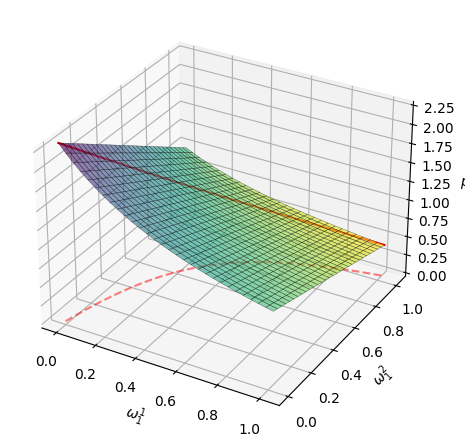

In [20]:
y,x = np.meshgrid(Man_baseline.Grid_1, Man_baseline.Grid_2)
z = np.reshape(Man_baseline.Result[:,2], (Man_baseline.Grid_1.__len__(), Man_baseline.Grid_1.__len__())) 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(Man_baseline.NonTradeSet[:,0], Man_baseline.NonTradeSet[:,1], Man_baseline.NonTradeSet[:,2], color = 'red')
ax.plot(Man_baseline.NonTradeSet[:,0], Man_baseline.NonTradeSet[:,1], np.zeros_like(Man_baseline.NonTradeSet[:,2]), linestyle = '--', color = 'red', alpha = 0.5)
ax.plot_surface(x,y,z, cmap='viridis_r', linewidth=0.3, alpha = 0.6, edgecolor = 'k')
# ax.legend(['no-trade Equilibria'])
ax.set_zlim(0, 2.25)
ax.set_xlabel(r'$\omega_1^1$')
ax.set_ylabel(r'$\omega_1^2$')
ax.set_zlabel(r'$p$')
bbox = fig.bbox_inches.from_bounds(1, 2, 5.5, 6)
plt.savefig('Manifold_log.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

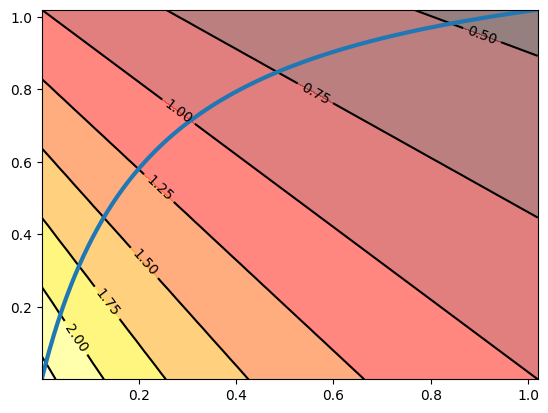

In [21]:
plt.contourf(x, y, z, linewidth=0, alpha = 0.5, cmap = plt.cm.hot)
C = plt.contour(x, y, z, linewidth=0, antialiased=True, colors = 'black')
plt.clabel(C, inline = 1, fontsize = 10)
plt.plot(Man_baseline.E_contract[:,2], Man_baseline.E_contract[:,3], linewidth = 3)
plt.savefig('Contract_log.png', dpi=300, bbox_inches='tight')